In [1]:
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.transform import Affine
from rasterio.plot import show
from rasterio.plot import show_hist
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd  

Wczywanie arkusza mapy

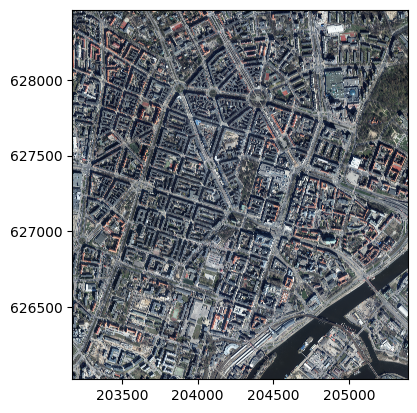

<Axes: >

In [2]:
img = rasterio.open('mapa5-10cm-a3-4.tif') #zmienić nazwę
mapa = img.read(1)

show(source =img)



Wczytanie danych topograficznych budynków

In [3]:
import geopandas as gpd
df = gpd.read_file('budynki_szczecin.geojson')

df.head()


,fid,czyobiektb,x_kod,x_skrkarto,x_aktualno,liczbakond,nazwa,zabytek,geometria_,typ_budynku,centroid,bbox_20m,geometry
0,1,0,BUBD07,biur.,2011-07-19,1,NaN,0,27.307827,biura i usługi,Point (203925.23107874 629767.29504305),"Polygon ((203926.29459005 629742.56175027, 203...","MULTIPOLYGON (((203930.080 629767.590, 203926...."
1,2,0,BUBD08,unknown,2011-07-19,2,NaN,0,60.451562,biura i usługi,Point (203126.3259111 626017.28379273),"Polygon ((203116.37840499 625992.21047891, 203...","MULTIPOLYGON (((203136.390 626022.370, 203136...."
2,3,0,BUBD07,biur.,2011-07-19,1,NaN,0,59.376168,biura i usługi,Point (201583.62623073 623953.41594856),"Polygon ((201581.92428752 623924.98635866, 201...","MULTIPOLYGON (((201589.510 623960.300, 201590...."
3,4,0,BUBD17,h. sport.,2011-07-19,1,NaN,0,74.153511,NaN,Point (202555.63005979 623970.62255884),"Polygon ((202560.56597896 623937.95368714, 202...","MULTIPOLYGON (((202569.080 623967.560, 202560...."
4,5,0,BUBD18,bud.,2011-07-19,7,NaN,1,46.821008,przemysłowe,Point (203287.60137262 630636.14281446),"Polygon ((203288.34371084 630608.75609469, 203...","MULTIPOLYGON (((203294.750 630638.510, 203294...."


Uzyskanie danych o buforze 20m

In [4]:
from shapely.geometry import MultiPolygon, Polygon
from shapely import wkt

col_bbox = df['bbox_20m']
col_load= wkt.loads(col_bbox)
col_multi = col_load.apply(lambda x: MultiPolygon([x]))
print(col_multi)

0        MULTIPOLYGON (((203926.29459005 629742.5617502...
1        MULTIPOLYGON (((203116.37840499 625992.2104789...
2        MULTIPOLYGON (((201581.92428752 623924.9863586...
3        MULTIPOLYGON (((202560.56597896 623937.9536871...
4        MULTIPOLYGON (((203288.34371084 630608.7560946...
                               ...                        
42411    MULTIPOLYGON (((205027.01393076 626988.1529943...
42412    MULTIPOLYGON (((201228.9723275 625356.12102344...
42413    MULTIPOLYGON (((211750.74926115 622385.9209926...
42414    MULTIPOLYGON (((206800.83944162 630301.9000105...
42415    MULTIPOLYGON (((212592.26410017 623749.4600322...
Name: bbox_20m, Length: 42416, dtype: object


Wstawienie danych

In [5]:
df['bbox_20m'] = col_multi
df.head()


,fid,czyobiektb,x_kod,x_skrkarto,x_aktualno,liczbakond,nazwa,zabytek,geometria_,typ_budynku,centroid,bbox_20m,geometry
0,1,0,BUBD07,biur.,2011-07-19,1,NaN,0,27.307827,biura i usługi,Point (203925.23107874 629767.29504305),MULTIPOLYGON (((203926.29459005 629742.5617502...,"MULTIPOLYGON (((203930.080 629767.590, 203926...."
1,2,0,BUBD08,unknown,2011-07-19,2,NaN,0,60.451562,biura i usługi,Point (203126.3259111 626017.28379273),MULTIPOLYGON (((203116.37840499 625992.2104789...,"MULTIPOLYGON (((203136.390 626022.370, 203136...."
2,3,0,BUBD07,biur.,2011-07-19,1,NaN,0,59.376168,biura i usługi,Point (201583.62623073 623953.41594856),MULTIPOLYGON (((201581.92428752 623924.9863586...,"MULTIPOLYGON (((201589.510 623960.300, 201590...."
3,4,0,BUBD17,h. sport.,2011-07-19,1,NaN,0,74.153511,NaN,Point (202555.63005979 623970.62255884),MULTIPOLYGON (((202560.56597896 623937.9536871...,"MULTIPOLYGON (((202569.080 623967.560, 202560...."
4,5,0,BUBD18,bud.,2011-07-19,7,NaN,1,46.821008,przemysłowe,Point (203287.60137262 630636.14281446),MULTIPOLYGON (((203288.34371084 630608.7560946...,"MULTIPOLYGON (((203294.750 630638.510, 203294...."


Skorygowanie listy budynków do wyznacznych na wczytanej mapie

In [6]:
gdf = df.loc[df['x_kod']=='BUBD07']


bounds=img.bounds
print(bounds)
gdf_bbox = gdf.cx[bounds.left:bounds.right,bounds.bottom:bounds.top]
#gdf2 = gdf.cx[203171.9:205390.8,626019.8:628464.7]

print(len(gdf_bbox))
gdf_bbox.head()

BoundingBox(left=203171.90000000002, bottom=626019.8, right=205390.80000000002, top=628464.7000000001)
206


,fid,czyobiektb,x_kod,x_skrkarto,x_aktualno,liczbakond,nazwa,zabytek,geometria_,typ_budynku,centroid,bbox_20m,geometry
14,15,0,BUBD07,biur.,2011-07-19,2,NaN,1,212.107616,biura i usługi,Point (204376.1277378 626131.87391354),MULTIPOLYGON (((204368.11597534 626072.8202302...,"MULTIPOLYGON (((204412.420 626141.180, 204397...."
59,60,0,BUBD07,unknown,2011-07-19,4,NaN,0,148.042938,biura i usługi,Point (204203.38920403 628439.71586742),MULTIPOLYGON (((204211.07744206 628390.3109746...,"MULTIPOLYGON (((204223.200 628416.710, 204210...."
63,64,0,BUBD07,biur.,2011-07-19,2,NaN,0,110.235522,biura i usługi,Point (203983.92581585 628477.41877276),MULTIPOLYGON (((203975.38590212 628441.7201085...,"MULTIPOLYGON (((204002.330 628475.450, 203995...."
68,69,0,BUBD07,UM,2011-07-19,5,NaN,1,1280.191653,biura i usługi,Point (204107.77801143 628500.12623099),MULTIPOLYGON (((204034.00019551 628395.3203035...,"MULTIPOLYGON (((204206.690 628514.820, 204192...."
72,73,0,BUBD07,biur.,2011-07-19,5,NaN,0,141.700469,biura i usługi,Point (205306.25062731 628244.06157364),MULTIPOLYGON (((205301.5398467 628206.81483721...,"MULTIPOLYGON (((205312.180 628258.420, 205327...."


Wydzielenie poszczególnych kategorii

In [7]:
spis = []

for i in range(21):
    if i < 9 :
        gdf = df.loc[df['x_kod']==f'BUBD0{i+1}']
        gdf2 = gdf.cx[bounds.left:bounds.right,bounds.bottom:bounds.top]
        number = len(gdf2)
        spis.append(number)
    else :
        gdf = df.loc[df['x_kod']==f'BUBD{i+1}']
        gdf2 = gdf.cx[bounds.left:bounds.right,bounds.bottom:bounds.top]
        number = len(gdf2)
        spis.append(number)
print(spis)

[27, 0, 2180, 54, 42, 1, 206, 155, 7, 188, 35, 102, 11, 14, 109, 35, 7, 340, 15, 0, 32]


Wyizolowanie pojedyńczego obrazu

206
5: MULTIPOLYGON (((204615.39623534 626596.99106335, 204614.33259559 626597.00838701, 204613.27138151 626597.08224013, 204612.21559535 626597.21241377, 204611.16822399 626597.39853967, 204610.13223054 626597.64009127, 204609.11054589 626597.93638518, 204600.93054588 626600.54638518, 204577.30290448 626608.15254149, 204576.28412871 626608.48999911, 204568.53412871 626611.28999911, 204567.54382206 626611.67785482, 204566.57553354 626612.11780556, 204565.63200132 626612.60860722, 204564.71589356 626613.14887188, 204563.82980089 626613.73707176, 204562.97622904 626614.37154352, 204562.15759178 626615.05049297, 204561.3762041 626615.77200014, 204560.63427563 626616.53402473, 204559.93390443 626617.33441183, 204559.27707107 626618.17089808, 204558.66563295 626619.04111802, 204558.10131913 626619.9426108, 204557.5857254 626620.87282713, 204557.1203098 626621.82913652, 204556.70638843 626622.80883464, 204556.34513182 626623.80915108, 204556.03756153 626624.82725709, 204555.78454733 626625.8

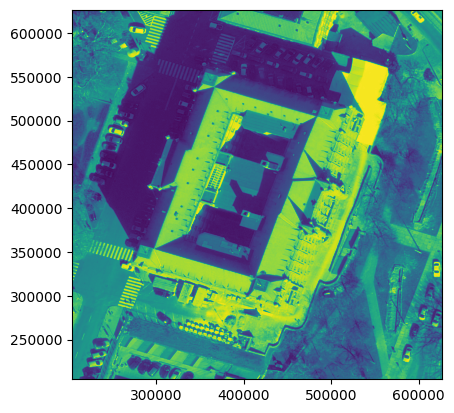

In [9]:
gdf3 = gdf_bbox['bbox_20m']
n =len(gdf3)
print(n)
gdf5 = gdf3.iloc[25]
print('5:',gdf5)

bbox = gdf5.bounds
print('bbox',bbox)
window1 = img.window(*bbox)
print('window',window1)
mapa1 = img.read(1,window=window1)
plt.imshow(mapa1, extent=bbox)



Pojedyńczy obraz 

MULTIPOLYGON (((204615.39623534 626596.99106335, 204614.33259559 626597.00838701, 204613.27138151 626597.08224013, 204612.21559535 626597.21241377, 204611.16822399 626597.39853967, 204610.13223054 626597.64009127, 204609.11054589 626597.93638518, 204600.93054588 626600.54638518, 204577.30290448 626608.15254149, 204576.28412871 626608.48999911, 204568.53412871 626611.28999911, 204567.54382206 626611.67785482, 204566.57553354 626612.11780556, 204565.63200132 626612.60860722, 204564.71589356 626613.14887188, 204563.82980089 626613.73707176, 204562.97622904 626614.37154352, 204562.15759178 626615.05049297, 204561.3762041 626615.77200014, 204560.63427563 626616.53402473, 204559.93390443 626617.33441183, 204559.27707107 626618.17089808, 204558.66563295 626619.04111802, 204558.10131913 626619.9426108, 204557.5857254 626620.87282713, 204557.1203098 626621.82913652, 204556.70638843 626622.80883464, 204556.34513182 626623.80915108, 204556.03756153 626624.82725709, 204555.78454733 626625.86027361

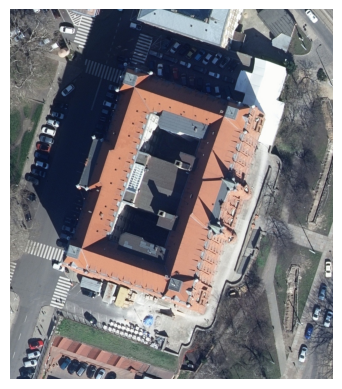

In [10]:
print(gdf5)
bbox3 = gdf5.bounds
print(bbox3)
windo3 = img.window(*bbox3)
print(windo3)

# Read the windowed region of the raster data
raster_data = img.read(window=windo3)

# Specify the transform for the windowed region
window_transform = img.window_transform(windo3)

# Plot the windowed region
fig, ax = plt.subplots()
show(raster_data, ax=ax, transform=window_transform)

# Display the windowed region
plt.axis('off')
plt.savefig("test.png",bbox_inches='tight',pad_inches = 0)
plt.show()


Stworzenie listy obrazów dla każdej wybranej kategorii

In [14]:
Buildings = ['BUBD01','BUBD03','BUBD04','BUBD05','BUBD07','BUBD08','BUBD10','BUBD11','BUBD12','BUBD15','BUBD16','BUBD18']
n_build = len(Buildings)
gdf_all = gdf_bbox['bbox_20m']

bounds=img.bounds
print(bounds)

def loop_build(): 
    for i in Buildings:
        print(i)
        gdf = df.loc[df['x_kod']==i]
        gdf_bbox = gdf.cx[bounds.left:bounds.right,bounds.bottom:bounds.top]
        gdf_all = gdf_bbox['bbox_20m']
        n_all = len(gdf_all)
        print(n_all)
        for j in range(n_all):
            #print(j)
            gdf_loop = gdf_all.iloc[j]
            #print(gdf_loop)
            bbox_loop = gdf_loop.bounds
            window_loop = img.window(*bbox_loop)
            raster_data_loop = img.read(window=window_loop)
            window_transform_loop = img.window_transform(window_loop)
            fig, ax = plt.subplots()
            show(raster_data_loop, ax=ax, transform=window_transform_loop)

            # Display the windowed region
            plt.axis('off')
            plt.savefig(f"dataset/{i}/{i}_a3-4_{j+1}.png",bbox_inches='tight',pad_inches = 0)
            plt.close()

    
if __name__=="__main__":
    loop_build()
    print("finish")
  

BoundingBox(left=203171.90000000002, bottom=626019.8, right=205390.80000000002, top=628464.7000000001)
BUBD01
27
BUBD03
2180
BUBD04
54
BUBD05
42
BUBD07
206
BUBD08
155
BUBD10
188
BUBD11
35
BUBD12
102
BUBD15
109
BUBD16
35
BUBD18
340
finish


In [ ]:
for i in range (n):
    print(i)
    gdf_loop = gdf3.iloc[i]
    #print(gdf_loop)
    bbox_loop = gdf_loop.bounds
    window_loop = img.window(*bbox_loop)
    raster_data_loop = img.read(window=window_loop)
    window_transform_loop = img.window_transform(window_loop)
    fig, ax = plt.subplots()
    show(raster_data_loop, ax=ax, transform=window_transform_loop)

    # Display the windowed region
    plt.axis('off')
    plt.savefig(f"data/BUBD07/BUBD07_a34-{i+1}.png",bbox_inches='tight',pad_inches = 0)
    #plt.show()

In [ ]:
mapa_transform = img.window_transform(window1)



with rasterio.open('07mapa.tif', #filename
                   'w', # file mode, with 'w' standing for "write"
                   driver='GTiff', # format to write the data
                   height=mapa1.shape[0], # height of the image, often the height of the array
                   width=mapa1.shape[1], # width of the image, often the width of the array
                   count=1, # the number of bands to write
                   dtype=rasterio.ubyte, # the dtype of the data, usually `ubyte` if data is stored in integers
                   crs=img.crs, # the coordinate reference system of the data
                   transform=mapa_transform # the affine transformation for the image
                  ) as outfile:
    outfile.write(mapa1,indexes=2) # write the `austin_nightlights` as the first band


In [ ]:
import fiona
import rasterio
import rasterio.mask
from rasterio.windows import Window
from pyproj import Transformer


# To mask the data

with fiona.open("budynki_szczecin2.geojson", "r") as shapefile:
  for feature in shapefile:
    shapes = [feature['geometry']]
    with rasterio.open("mapa10cm.tif") as src:
      out_image, transformed = rasterio.mask.mask(src, shapes, crop=True)
      out_meta = src.meta 

In [ ]:
show(out_image)

In [ ]:
import contextily

basemap, basemap_extent = contextily.bounds2img(*gdf_07.to_crs(epsg=3857).total_bounds, 
                                                zoom=10)


plt.figure(figsize=(10,10))
plt.imshow(img)
gdf_07.to_crs(epsg=3857).plot('hot', 
                                      ax = plt.gca(), alpha=0)
plt.axis(gdf_07.to_crs(epsg=3857).total_bounds[[0,2,1,3]])